In [1]:
using Revise

# Comparison with an Discrete Wright-Fisher chain and an Euler-Maruyama scheme

In [2]:
using Random, Distributions
Random.seed!(1)

N = 10^6
a = 10
b = 20
alpha = a/N
beta = b/N 
T = N
delta = 1/T

x = Array{Float64}(undef, N)
y = Array{Float64}(undef, N)
x[1] = rand(1:N)
y[1] = x[1] * 1. / N
wn = rand(Normal(0,sqrt(delta)), T)
for t in 2:N
  # WF transition
  p_x = alpha + (1-alpha-beta) * x[t-1]/N
  x[t] = rand(Binomial(N, p_x))
  # Euler scheme
  mu = a*(1-y[t-1])-b*y[t-1]
  sigma = sqrt(y[t-1] * (1-y[t-1]))
  y[t] = y[t-1] + mu*delta + sigma*wn[t]
end

In [3]:
using ExactWrightFisher
Exact_wf_trajectory = Wright_Fisher_exact_trajectory_with_t005_approx(y[1], range(0, stop = 1, length = 10000), 2*a, 2*b) 

10001-element Array{Float64,1}:
 0.402607           
 0.402607           
 0.3996228914310916 
 0.4040172344418154 
 0.4131800203396575 
 0.41484437511564265
 0.4156893201740781 
 0.39977323936930054
 0.4040490535445318 
 0.41147222527341815
 0.4150276059903747 
 0.40875303410231245
 0.4045999835154906 
 ⋮                  
 0.22205969450024188
 0.22749861515712932
 0.2270209464699284 
 0.2286026916477709 
 0.2256517039911688 
 0.23000200683127578
 0.2399447817320388 
 0.23964408576092175
 0.23677719009701384
 0.23801738026548877
 0.23075989497735563
 0.23070844175002103

In [4]:
using RCall
R"suppressPackageStartupMessages(library(tidyverse))"

RObject{StrSxp}
 [1] "dplyr"     "purrr"     "readr"     "tidyr"     "tibble"    "ggplot2"  
 [7] "tidyverse" "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[13] "methods"   "base"     


┌ Warning: RCall.jl: Warning: Ignoring unknown aesthetics: fill
└ @ RCall /home/guillaume/.julia/packages/RCall/Q4n8R/src/io.jl:110


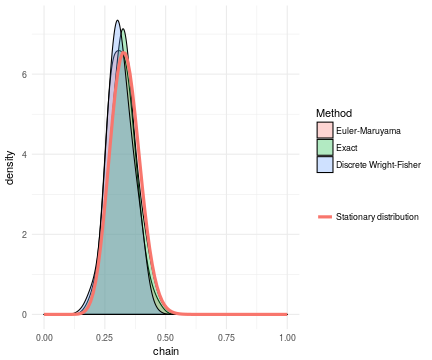

RObject{VecSxp}


In [5]:
R"tibble(WF_chain = $(x/N), Euler_Maruyama = $y) %>% 
      gather(type, chain) %>% 
      rbind(tibble(type = 'Exact', chain = $Exact_wf_trajectory)) %>% 
      ggplot(aes(x = chain, fill = type)) + 
      theme_minimal() + 
      geom_density(alpha = 0.3, bw = .02) + 
      geom_line(data = tibble(x = seq(0, 1, length.out = 100)) %>% 
                        mutate(y = dbeta(x, 2*$a, 2*$b)), 
                aes(x = x, y = y, fill = NULL, colour = 'Stationary distribution'), size = 1.5) + 
      scale_fill_discrete(name = 'Method', labels = c('Euler-Maruyama', 'Exact', 'Discrete Wright-Fisher')) +
      scale_colour_discrete(name = '', labels = c('Stationary distribution'))
"

In [6]:
Exact_wf_trajectory = Wright_Fisher_exact_trajectory_with_t005_approx(y[1], Float64.(1:1000), 2*a, 2*b);

┌ Warning: RCall.jl: Warning: Ignoring unknown aesthetics: fill
└ @ RCall /home/guillaume/.julia/packages/RCall/Q4n8R/src/io.jl:110


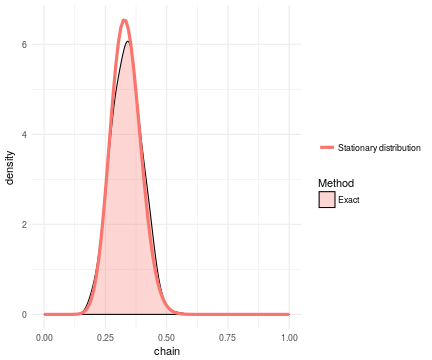

RObject{VecSxp}


In [7]:
R"tibble(type = 'Exact', chain = $Exact_wf_trajectory) %>% 
      ggplot(aes(x = chain, fill = type)) + 
      theme_minimal() + 
      geom_density(alpha = 0.3, bw = .02) + 
      geom_line(data = tibble(x = seq(0, 1, length.out = 100)) %>% 
                        mutate(y = dbeta(x, 2*$a, 2*$b)), 
                aes(x = x, y = y, fill = NULL, colour = 'Stationary distribution'), size = 1.5) + 
      scale_fill_discrete(name = 'Method') +
      scale_colour_discrete(name = '', labels = c('Stationary distribution'))
"

# Multidimensional Wright-Fisher compared against the marginal distribution

In [8]:
Random.seed!(0)
alpha_vec = Float64.(1:4)
Tf = 50000
WF_exact_trajectory = Wright_Fisher_K_dim_exact_trajectory(rand(Dirichlet(alpha_vec |> collect)), Float64.(1:Tf), alpha_vec)
WF_exact_trajectory_with_t005_approx = Wright_Fisher_K_dim_trajectory_with_t005_approx(rand(Dirichlet(alpha_vec |> collect)), Float64.(1:Tf), alpha_vec)

4×50001 Array{Float64,2}:
 0.0397463  0.21012    0.0495803  0.0670583  …  0.450712  0.119801  0.0624784
 0.171738   0.0592956  0.215846   0.291276      0.219571  0.271768  0.346614 
 0.210767   0.127715   0.339892   0.16538       0.207042  0.114725  0.196214 
 0.577748   0.60287    0.394681   0.476285      0.122675  0.493707  0.394694 

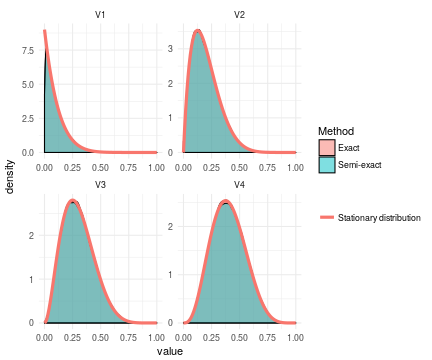

RObject{VecSxp}


In [9]:
R"as_tibble($WF_exact_trajectory %>% t) %>%
    mutate(Method = 'Exact') %>%
    bind_rows(as_tibble($WF_exact_trajectory_with_t005_approx %>% t) %>%
    mutate(Method = 'Semi-exact')) %>% 
  gather(margin, value, V1:V4) %>% 
  ggplot(aes(x = value)) + 
  geom_density(aes(fill = Method), alpha = 0.5) + 
  facet_wrap(~margin, scales = 'free') + 
  theme_minimal() + 
  geom_line(data = $alpha_vec %>% 
  (function(alphavec){
    lapply(seq_along(alphavec), FUN = function(i) tibble(x = seq(0, 1, length.out = 100)) %>% mutate(margin = paste('V', i, sep = ''), y = dbeta(x, alphavec[i], sum(alphavec)-alphavec[i])))
  }) %>% 
  bind_rows(), aes(x = x, y = y, colour = 'Stationary distribution'), size = 1.5)  +
      scale_colour_discrete(name = '', labels = c('Stationary distribution'))"